In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

# Let's do a quick and dirty detrend

In [3]:
air_passengers = pd.read_csv("air_passanger.csv", header = 0, parse_dates = [0], names = ['Month', 'Passengers'], index_col = 0)

In [5]:
log_air_passengers = np.log(air_passengers.Passengers) # Due to variance gets bigger and bigger as time goes.

In [6]:
log_air_passengers_diff = log_air_passengers - log_air_passengers.shift() # Also difference it to make it stationary

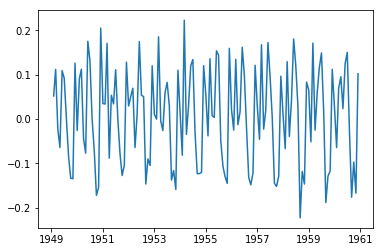

In [7]:
plt.plot(log_air_passengers_diff)

### By the way, how would I difference again?

c:\python27\lib\site-packages\ipykernel_launcher.py:5: MatplotlibDeprecationWarning: The set_color_cycle function was deprecated in version 1.5. Use `.set_prop_cycle` instead.
  """


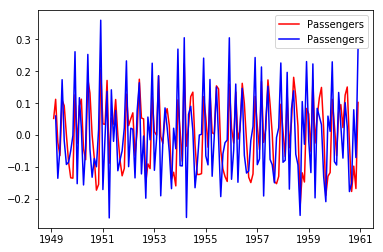

In [8]:
# %load snippets/7_diff2.py

log_air_passengers_diff_2 = log_air_passengers_diff - log_air_passengers_diff.shift()
fig, ax = plt.subplots()
ax.set_color_cycle(['red', 'blue'])
plt.plot(log_air_passengers_diff)
plt.plot(log_air_passengers_diff_2)
plt.legend(loc = 'best')

### What information are you losing when you difference? What about when you difference twice?

In [9]:
log_air_passengers_diff.dropna(inplace=True)

In [10]:
# try out nc, ct, ctt
# http://www.statsmodels.org/0.6.1/generated/statsmodels.tsa.stattools.adfuller.html
from statsmodels.tsa.stattools import adfuller
useful_values_raw = adfuller(log_air_passengers_diff, autolag = 'AIC', regression = 'c')[:5]
useful_values = [v for v in useful_values_raw[:4]]
useful_values.extend([useful_values_raw[4]['1%'], useful_values_raw[4]['5%'], useful_values_raw[4]['10%']])
pd.DataFrame({ 'Value':useful_values, 'Label':['Test Statistic','p-value','#Lags Used','Number of Observations Used', 'Critical value for 1%', 'Critical value for 5%', 'Critical value for 10%']})

# NOTE: Here the p-values is very low so maybe not good to go ahead.

,Label,Value
0,Test Statistic,-2.717131
1,p-value,0.071121
2,#Lags Used,14.000000
3,Number of Observations Used,128.000000
4,Critical value for 1%,-3.482501
5,Critical value for 5%,-2.884398
6,Critical value for 10%,-2.578960


In [ ]:
# Let's talk about the ARIMA model
# Auto-Regressive Integrated Moving Average
# In this case we're talking about a series with dependence among values (more natural)

In [ ]:
# Nothing but a linear regression with a few times
# 1. The number of Auto-Regressive Terms (p)
# 2. The number of differences taken (d)
# 3. The number of Moving Average Terms (q)

# Let's do it

In [11]:
# We don't pull these out of thin air, but rather draw them from the data
from statsmodels.tsa.stattools import acf, pacf

lag_acf = acf(log_air_passengers_diff.values, nlags = 20)
lag_pacf = pacf(log_air_passengers_diff.values, nlags = 20)

c:\python27\lib\site-packages\matplotlib\__init__.py:1855: MatplotlibDeprecationWarning: The *left* kwarg to `bar` is deprecated use *x* instead. Support for *left* will be removed in Matplotlib 3.0
  return func(ax, *args, **kwargs)


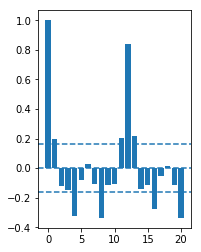

In [14]:
plt.subplot(121) 
plt.bar(left = range(len(lag_acf)), height = lag_acf)
plt.axhline(y=0,linestyle='--')
plt.axhline(y=-1.96/np.sqrt(len(log_air_passengers_diff)),linestyle='--')
plt.axhline(y=1.96/np.sqrt(len(log_air_passengers_diff)),linestyle='--')

# NOTE: Here it looks like AR(1) process. Because the val1 in the plot has good correlation with 0.

In [ ]:
# look at where the plot crosses the upper confidence interval for the first time
# for ACF this is 1 and gives us the p value

c:\python27\lib\site-packages\matplotlib\__init__.py:1855: MatplotlibDeprecationWarning: The *left* kwarg to `bar` is deprecated use *x* instead. Support for *left* will be removed in Matplotlib 3.0
  return func(ax, *args, **kwargs)


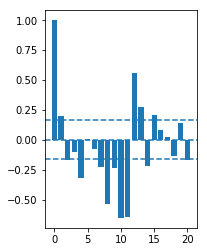

In [18]:
plt.subplot(121) 
plt.bar(left = range(len(lag_pacf)), height = lag_pacf)
plt.axhline(y=0,linestyle='--')
plt.axhline(y=-1.96/np.sqrt(len(log_air_passengers_diff)),linestyle='--')
plt.axhline(y=1.96/np.sqrt(len(log_air_passengers_diff)),linestyle='--')

# NOTE: Here it looks like AR(1) or AR(2) process. Because the val1 in the plot has good correlation with 0. 
# Also the 2nd observation is almost at the line. so... The others are due to seasonality.

In [ ]:
# look at where the plot crosses the upper confidence interval for the first time
# for PACF this is 2 and gives us the p value

In [16]:
from statsmodels.tsa.arima_model import ARIMA

c:\python27\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
c:\python27\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Text(0.5,1,'RSS: 1.5023')

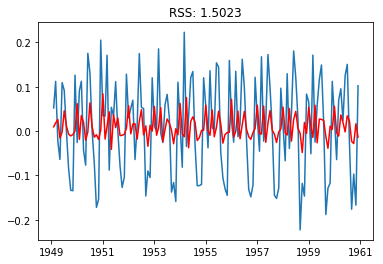

In [21]:
# AR model
# try different values of p
#(p,d,q)=
model = ARIMA(log_air_passengers, order=(2, 1, 0))  
results_AR = model.fit(disp=-1)  
plt.plot(log_air_passengers_diff)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-log_air_passengers_diff)**2))

c:\python27\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
c:\python27\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Text(0.5,1,'RSS: 1.5245')

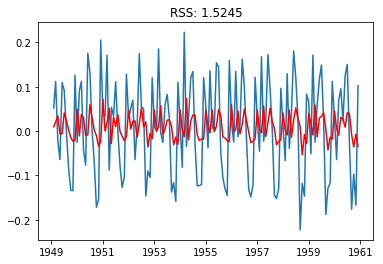

In [19]:
# try different values of q
# MA model
model = ARIMA(log_air_passengers, order=(0, 1, 1))  
results_MA = model.fit(disp=-1)  
plt.plot(log_air_passengers_diff)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_MA.fittedvalues-log_air_passengers_diff)**2))

c:\python27\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
c:\python27\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Text(0.5,1,'RSS: 1.4597')

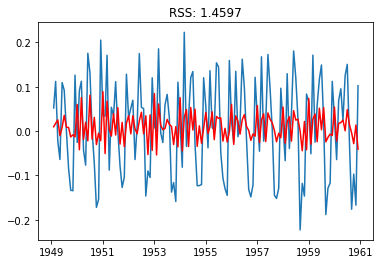

In [20]:
# ARIMA model
# try p = 1 or 2
model = ARIMA(log_air_passengers, order=(1, 1, 1))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(log_air_passengers_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-log_air_passengers_diff)**2))

In [ ]:
# should we do un-log and then un-diff?
# or un-diff and then un-log?
# let's go back and see what we did

In [22]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print(predictions_ARIMA_diff.head())

Month
1949-02-01    0.009800
1949-03-01    0.017618
1949-04-01    0.025229
1949-05-01   -0.010225
1949-06-01    0.008528
dtype: float64


In [23]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print(predictions_ARIMA_diff_cumsum.head())

Month
1949-02-01    0.009800
1949-03-01    0.027418
1949-04-01    0.052648
1949-05-01    0.042422
1949-06-01    0.050950
dtype: float64


In [24]:
predictions_ARIMA_log = pd.Series(log_air_passengers.iloc[0], index=log_air_passengers.index)

In [25]:
predictions_ARIMA_log = pd.Series(log_air_passengers.ix[0], index=log_air_passengers.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

Month
1949-01-01    4.718499
1949-02-01    4.728299
1949-03-01    4.745917
1949-04-01    4.771146
1949-05-01    4.760921
dtype: float64

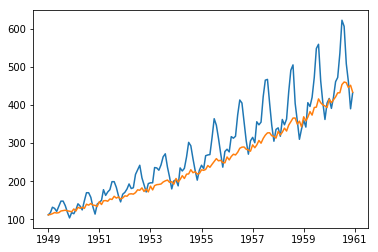

In [26]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(air_passengers)
plt.plot(predictions_ARIMA)

# Know more

In [ ]:
# Seasonal ARIMA
# http://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html
# Confidence interval for ARIMA 
# http://statsmodels.sourceforge.net/devel/generated/statsmodels.tsa.arima_model.ARIMAResults.forecast.html#statsmodels.tsa.arima_model.ARMAResults.forecast